In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform, RandomNormal
import random, os, pickle, copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
%matplotlib inline
savedir = os.path.join('./save/transfer_learning_cifar5_multiple_instantiations')
fig_dir = os.path.join(os.getenv('HOME'), 'Dropbox/uniqueness_cnn_figures')

Using TensorFlow backend.


# SET UP DATA

In [2]:
def map_to_range(arr):
    narr = np.zeros_like(arr, dtype=np.int64)
    vals = np.unique(arr)
    for i, v in enumerate(vals):
        mask = (arr == v)
        narr[mask] = i
    return narr

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
input_shape = (32, 32, 3)
num_classes = 5

y_test = y_test.astype(np.int64).squeeze()
y_train = y_train.astype(np.int64).squeeze()

# labels found to give roughly equal classification performance
set_1_test_mask = np.isin(y_test, np.array([0, 3, 4, 6, 7])).squeeze()
set_1_train_mask = np.isin(y_train, np.array([0, 3, 4, 6, 7])).squeeze()

set_2_test_mask = np.isin(y_test, np.array([1, 2, 5, 8, 9])).squeeze()
set_2_train_mask = np.isin(y_train, np.array([1, 2, 5, 8, 9])).squeeze()

set_1_train_labels = y_train[set_1_train_mask]
x_train_1 = x_train[set_1_train_mask]
set_1_test_labels = y_test[set_1_test_mask]
x_test_1 = x_test[set_1_test_mask]
set_2_train_labels = y_train[set_2_train_mask]
x_train_2 = x_train[set_2_train_mask]
set_2_test_labels = y_test[set_2_test_mask]
x_test_2 = x_test[set_2_test_mask]

y_train_1 = keras.utils.to_categorical(map_to_range(set_1_train_labels), num_classes)
y_train_2 = keras.utils.to_categorical(map_to_range(set_2_train_labels), num_classes)
y_test_1 = keras.utils.to_categorical(map_to_range(set_1_test_labels), num_classes)
y_test_2 = keras.utils.to_categorical(map_to_range(set_2_test_labels), num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
np.unique(y_test, return_index=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 3,  6, 25,  0, 22, 12,  4, 13,  1, 11]))

In [5]:
datagen1 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen1.fit(x_train_1)

datagen2= ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
datagen2.fit(x_train_2)

In [6]:
def set_up_model(lr=1e-3, trainable=[True, True, True, True]):
    keras.backend.clear_session()
    inputs = Input(shape=input_shape)
    x = Conv2D(4, kernel_size=(7,7), strides=(1, 1), activation='relu', padding='same', trainable=trainable[0])(inputs)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(8, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', trainable=trainable[1])(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Conv2D(16, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same', trainable=trainable[2])(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', trainable=trainable[3])(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=['accuracy'])
    return model

# Multiple instantiations of transfer learning

Using first-layer filters trained on dset2 were able to match performance on dset1 compared to first-layer filters trained on dset1, but not the other way around. Doing this procedure 10 times to see if the results are stable.

In [ ]:
epochs = 100
batch_size = 128

for i in range(10):
    ##### DSET1 #####
    # Train model from scratch
    model = set_up_model(trainable=[True, True, True, True])
    ckpt_training = ModelCheckpoint(os.path.join(savedir, 'weights_training_dset1_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False,
                                    mode='auto', 
                                    period=1
                                   )
    
    history_training_dset1 = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                  epochs=epochs,
                                  verbose=2,
                                  validation_data=(x_test_1, y_test_1),
                                  callbacks=[ckpt_training]
                                  )
    with open(os.path.join(savedir, 'history_training_dset1_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_training_dset1.history, f)
    
    # Freeze first layer and load best performing network state
    model = set_up_model(trainable=[False, True, True, True])
    model.load_weights(os.path.join(savedir, 'weights_training_dset1_%d.h5'%i))
    orig_weights = model.get_weights()
    nweights = copy.deepcopy(orig_weights[:2])
    for w in orig_weights[2:]:
        nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))

   
    # Train on same dset
    model.set_weights(nweights)
    ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_transfer_dset1_dset1_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
                       
    history_transfer_dset1_dset1 = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                                 epochs=epochs,
                                                 verbose=2,
                                                 validation_data=(x_test_1, y_test_1),
                                                 callbacks=[ckpt_transfer]
                                                 )

    with open(os.path.join(savedir, 'history_transfer_dset1_dset1_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_transfer_dset1_dset1.history, f)
        
        
        
    # Train on opposite dset
    model = set_up_model(trainable=[False, True, True, True])
    model.set_weights(nweights)
    ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_transfer_dset1_dset2_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
                       
    history_transfer_dset1_dset2 = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                                                 epochs=epochs,
                                                 verbose=2,
                                                 validation_data=(x_test_2, y_test_2),
                                                 callbacks=[ckpt_transfer]
                                                 )

    with open(os.path.join(savedir, 'history_transfer_dset1_dset2_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_transfer_dset1_dset2.history, f)
                       

            
            
            
                       
                       
    #### DSET2 #####
    # Train model from scratch
    model = set_up_model(trainable=[True, True, True, True])
    ckpt_training = ModelCheckpoint(os.path.join(savedir, 'weights_training_dset2_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False,
                                    mode='auto', 
                                    period=1
                                   )
    
    history_training_dset2 = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                                                 epochs=epochs,
                                                 verbose=2,
                                                 validation_data=(x_test_2, y_test_2),
                                                 callbacks=[ckpt_training]
                                                 )
                       
    with open(os.path.join(savedir, 'history_training_dset2_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_training_dset2.history, f)
    
    # Freeze first layer and load best performing network state
    model = set_up_model(trainable=[False, True, True, True])
    model.load_weights(os.path.join(savedir, 'weights_training_dset2_%d.h5'%i))
    orig_weights = model.get_weights()
    nweights = copy.deepcopy(orig_weights[:2])
    for w in orig_weights[2:]:
        nweights.append(glorot_uniform()(w.shape).eval(session=keras.backend.get_session()))
    
    # Train on same dset
    model.set_weights(nweights)
    ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_transfer_dset2_dset2_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1
                                   )
                       
    history_transfer_dset2_dset2 = model.fit_generator(datagen2.flow(x_train_2, y_train_2, batch_size=batch_size),
                                                 epochs=epochs,
                                                 verbose=2,
                                                 validation_data=(x_test_2, y_test_2),
                                                 callbacks=[ckpt_transfer]
                                                 )

    with open(os.path.join(savedir, 'history_transfer_dset2_dset2_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_transfer_dset2_dset2.history, f)
        
    # Train on opposite dset
    model = set_up_model(trainable=[False, True, True, True])
    model.set_weights(nweights)
    ckpt_transfer = ModelCheckpoint(os.path.join(savedir, 'weights_transfer_dset2_dset1_%d.h5'%i), 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1
                                   )
                       
    history_transfer_dset2_dset1 = model.fit_generator(datagen1.flow(x_train_1, y_train_1, batch_size=batch_size),
                                                 epochs=epochs,
                                                 verbose=2,
                                                 validation_data=(x_test_1, y_test_1),
                                                 callbacks=[ckpt_transfer]
                                                 )

    with open(os.path.join(savedir, 'history_transfer_dset2_dset1_%d.pkl'%i), 'wb') as f:
        pickle.dump(history_transfer_dset2_dset1.history, f)

Epoch 1/100
 - 11s - loss: 1.3568 - acc: 0.4249 - val_loss: 1.1614 - val_acc: 0.5492
Epoch 2/100
 - 9s - loss: 1.1896 - acc: 0.5252 - val_loss: 1.0730 - val_acc: 0.5852
Epoch 3/100
 - 9s - loss: 1.1226 - acc: 0.5577 - val_loss: 1.0017 - val_acc: 0.6164
Epoch 4/100
 - 9s - loss: 1.0833 - acc: 0.5751 - val_loss: 0.9608 - val_acc: 0.6242
Epoch 5/100
 - 9s - loss: 1.0585 - acc: 0.5857 - val_loss: 0.9540 - val_acc: 0.6336
Epoch 6/100
 - 9s - loss: 1.0305 - acc: 0.5993 - val_loss: 0.9331 - val_acc: 0.6392
Epoch 7/100
 - 9s - loss: 1.0051 - acc: 0.6091 - val_loss: 0.9069 - val_acc: 0.6384
Epoch 8/100
 - 9s - loss: 0.9919 - acc: 0.6123 - val_loss: 0.8765 - val_acc: 0.6644
Epoch 9/100
 - 9s - loss: 0.9741 - acc: 0.6218 - val_loss: 0.8609 - val_acc: 0.6668
Epoch 10/100
 - 9s - loss: 0.9607 - acc: 0.6259 - val_loss: 0.8547 - val_acc: 0.6662
Epoch 11/100
 - 9s - loss: 0.9446 - acc: 0.6328 - val_loss: 0.8493 - val_acc: 0.6678
Epoch 12/100
 - 9s - loss: 0.9358 - acc: 0.6406 - val_loss: 0.8367 - val_

Epoch 98/100
 - 9s - loss: 0.7107 - acc: 0.7308 - val_loss: 0.6138 - val_acc: 0.7704
Epoch 99/100
 - 9s - loss: 0.7170 - acc: 0.7306 - val_loss: 0.6324 - val_acc: 0.7572
Epoch 100/100
 - 9s - loss: 0.7082 - acc: 0.7333 - val_loss: 0.6102 - val_acc: 0.7688
Epoch 1/100
 - 9s - loss: 1.3969 - acc: 0.4045 - val_loss: 1.1318 - val_acc: 0.5622
Epoch 2/100
 - 9s - loss: 1.1706 - acc: 0.5358 - val_loss: 1.0418 - val_acc: 0.5998
Epoch 3/100
 - 9s - loss: 1.1068 - acc: 0.5644 - val_loss: 0.9814 - val_acc: 0.6226
Epoch 4/100
 - 9s - loss: 1.0521 - acc: 0.5942 - val_loss: 0.9411 - val_acc: 0.6406
Epoch 5/100
 - 9s - loss: 1.0162 - acc: 0.6080 - val_loss: 0.8956 - val_acc: 0.6540
Epoch 6/100
 - 9s - loss: 0.9922 - acc: 0.6149 - val_loss: 0.8843 - val_acc: 0.6562
Epoch 7/100
 - 9s - loss: 0.9685 - acc: 0.6269 - val_loss: 0.8701 - val_acc: 0.6600
Epoch 8/100
 - 9s - loss: 0.9545 - acc: 0.6344 - val_loss: 0.8380 - val_acc: 0.6804
Epoch 9/100
 - 9s - loss: 0.9396 - acc: 0.6368 - val_loss: 0.8330 - val_

Epoch 95/100
 - 9s - loss: 0.7323 - acc: 0.7250 - val_loss: 0.6781 - val_acc: 0.7470
Epoch 96/100
 - 9s - loss: 0.7374 - acc: 0.7257 - val_loss: 0.6729 - val_acc: 0.7440
Epoch 97/100
 - 9s - loss: 0.7335 - acc: 0.7233 - val_loss: 0.6714 - val_acc: 0.7526
Epoch 98/100
 - 9s - loss: 0.7379 - acc: 0.7238 - val_loss: 0.6794 - val_acc: 0.7416
Epoch 99/100
 - 9s - loss: 0.7470 - acc: 0.7201 - val_loss: 0.6763 - val_acc: 0.7434
Epoch 100/100
 - 9s - loss: 0.7387 - acc: 0.7239 - val_loss: 0.6667 - val_acc: 0.7530
Epoch 1/100
 - 9s - loss: 1.3652 - acc: 0.4147 - val_loss: 1.0648 - val_acc: 0.5716
Epoch 2/100
 - 9s - loss: 1.0820 - acc: 0.5547 - val_loss: 0.9208 - val_acc: 0.6208
Epoch 3/100
 - 9s - loss: 0.9932 - acc: 0.5940 - val_loss: 0.9122 - val_acc: 0.6274
Epoch 4/100
 - 9s - loss: 0.9591 - acc: 0.6065 - val_loss: 0.8583 - val_acc: 0.6570
Epoch 5/100
 - 9s - loss: 0.9108 - acc: 0.6334 - val_loss: 0.8087 - val_acc: 0.6734
Epoch 6/100
 - 9s - loss: 0.8905 - acc: 0.6412 - val_loss: 0.8293 - v

Epoch 92/100
 - 9s - loss: 0.6311 - acc: 0.7605 - val_loss: 0.5724 - val_acc: 0.7858
Epoch 93/100
 - 9s - loss: 0.6200 - acc: 0.7635 - val_loss: 0.5580 - val_acc: 0.7882
Epoch 94/100
 - 9s - loss: 0.6210 - acc: 0.7636 - val_loss: 0.5872 - val_acc: 0.7810
Epoch 95/100
 - 9s - loss: 0.6273 - acc: 0.7599 - val_loss: 0.5355 - val_acc: 0.7956
Epoch 96/100
 - 9s - loss: 0.6241 - acc: 0.7641 - val_loss: 0.5727 - val_acc: 0.7848
Epoch 97/100
 - 9s - loss: 0.6289 - acc: 0.7643 - val_loss: 0.5605 - val_acc: 0.7882
Epoch 98/100
 - 9s - loss: 0.6185 - acc: 0.7649 - val_loss: 0.5412 - val_acc: 0.7902
Epoch 99/100
 - 9s - loss: 0.6178 - acc: 0.7650 - val_loss: 0.5728 - val_acc: 0.7816
Epoch 100/100
 - 9s - loss: 0.6210 - acc: 0.7636 - val_loss: 0.5473 - val_acc: 0.7878
Epoch 1/100
 - 9s - loss: 1.2850 - acc: 0.4401 - val_loss: 1.0370 - val_acc: 0.5702
Epoch 2/100
 - 9s - loss: 1.0743 - acc: 0.5545 - val_loss: 0.9801 - val_acc: 0.5914
Epoch 3/100
 - 9s - loss: 1.0227 - acc: 0.5793 - val_loss: 0.9354 

Epoch 89/100
 - 9s - loss: 0.5969 - acc: 0.7739 - val_loss: 0.5243 - val_acc: 0.8058
Epoch 90/100
 - 9s - loss: 0.5939 - acc: 0.7753 - val_loss: 0.5349 - val_acc: 0.7956
Epoch 91/100
 - 9s - loss: 0.5904 - acc: 0.7778 - val_loss: 0.5377 - val_acc: 0.7972
Epoch 92/100
 - 9s - loss: 0.5869 - acc: 0.7756 - val_loss: 0.5495 - val_acc: 0.7910
Epoch 93/100
 - 9s - loss: 0.5874 - acc: 0.7784 - val_loss: 0.5216 - val_acc: 0.7996
Epoch 94/100
 - 9s - loss: 0.5886 - acc: 0.7762 - val_loss: 0.5243 - val_acc: 0.8052
Epoch 95/100
 - 9s - loss: 0.5935 - acc: 0.7746 - val_loss: 0.5199 - val_acc: 0.8026
Epoch 96/100
 - 9s - loss: 0.5900 - acc: 0.7767 - val_loss: 0.5529 - val_acc: 0.7942
Epoch 97/100
 - 9s - loss: 0.5786 - acc: 0.7803 - val_loss: 0.5192 - val_acc: 0.8052
Epoch 98/100
 - 9s - loss: 0.5788 - acc: 0.7823 - val_loss: 0.5686 - val_acc: 0.7884
Epoch 99/100
 - 9s - loss: 0.5785 - acc: 0.7825 - val_loss: 0.6020 - val_acc: 0.7768
Epoch 100/100
 - 9s - loss: 0.5802 - acc: 0.7815 - val_loss: 0.53

Epoch 86/100
 - 9s - loss: 0.6122 - acc: 0.7718 - val_loss: 0.6179 - val_acc: 0.7664
Epoch 87/100
 - 9s - loss: 0.6222 - acc: 0.7654 - val_loss: 0.5663 - val_acc: 0.7846
Epoch 88/100
 - 9s - loss: 0.6197 - acc: 0.7656 - val_loss: 0.5693 - val_acc: 0.7844
Epoch 89/100
 - 9s - loss: 0.6177 - acc: 0.7687 - val_loss: 0.5390 - val_acc: 0.7910
Epoch 90/100
 - 9s - loss: 0.6171 - acc: 0.7656 - val_loss: 0.6098 - val_acc: 0.7752
Epoch 91/100
 - 9s - loss: 0.6223 - acc: 0.7678 - val_loss: 0.5916 - val_acc: 0.7748
Epoch 92/100
 - 9s - loss: 0.6196 - acc: 0.7680 - val_loss: 0.6030 - val_acc: 0.7752
Epoch 93/100
 - 9s - loss: 0.6121 - acc: 0.7724 - val_loss: 0.5643 - val_acc: 0.7870
Epoch 94/100
 - 9s - loss: 0.6178 - acc: 0.7710 - val_loss: 0.5933 - val_acc: 0.7792
Epoch 95/100
 - 9s - loss: 0.6142 - acc: 0.7727 - val_loss: 0.5945 - val_acc: 0.7766
Epoch 96/100
 - 9s - loss: 0.6128 - acc: 0.7706 - val_loss: 0.5895 - val_acc: 0.7782
Epoch 97/100
 - 9s - loss: 0.6134 - acc: 0.7677 - val_loss: 0.565

Epoch 83/100
 - 9s - loss: 0.8052 - acc: 0.6945 - val_loss: 0.7532 - val_acc: 0.7160
Epoch 84/100
 - 9s - loss: 0.8004 - acc: 0.6975 - val_loss: 0.7322 - val_acc: 0.7238
Epoch 85/100
 - 9s - loss: 0.7999 - acc: 0.6957 - val_loss: 0.7272 - val_acc: 0.7242
Epoch 86/100
 - 9s - loss: 0.7956 - acc: 0.6960 - val_loss: 0.7349 - val_acc: 0.7226
Epoch 87/100
 - 9s - loss: 0.7963 - acc: 0.6981 - val_loss: 0.7121 - val_acc: 0.7338
Epoch 88/100
 - 9s - loss: 0.7921 - acc: 0.7027 - val_loss: 0.7400 - val_acc: 0.7200
Epoch 89/100
 - 9s - loss: 0.7944 - acc: 0.6999 - val_loss: 0.7192 - val_acc: 0.7316
Epoch 90/100
 - 8s - loss: 0.7910 - acc: 0.6997 - val_loss: 0.7104 - val_acc: 0.7320
Epoch 91/100
 - 9s - loss: 0.7931 - acc: 0.6976 - val_loss: 0.7323 - val_acc: 0.7172
Epoch 92/100
 - 9s - loss: 0.7917 - acc: 0.7025 - val_loss: 0.7131 - val_acc: 0.7308
Epoch 93/100
 - 9s - loss: 0.7932 - acc: 0.7005 - val_loss: 0.7078 - val_acc: 0.7364
Epoch 94/100
 - 9s - loss: 0.7929 - acc: 0.7025 - val_loss: 0.713

Epoch 80/100
 - 9s - loss: 0.7506 - acc: 0.7164 - val_loss: 0.6469 - val_acc: 0.7600
Epoch 81/100
 - 9s - loss: 0.7409 - acc: 0.7208 - val_loss: 0.6381 - val_acc: 0.7670
Epoch 82/100
 - 9s - loss: 0.7306 - acc: 0.7249 - val_loss: 0.6690 - val_acc: 0.7476
Epoch 83/100
 - 9s - loss: 0.7429 - acc: 0.7160 - val_loss: 0.6659 - val_acc: 0.7478
Epoch 84/100
 - 9s - loss: 0.7328 - acc: 0.7229 - val_loss: 0.6513 - val_acc: 0.7570
Epoch 85/100
 - 9s - loss: 0.7280 - acc: 0.7276 - val_loss: 0.6666 - val_acc: 0.7478
Epoch 86/100
 - 9s - loss: 0.7397 - acc: 0.7245 - val_loss: 0.6616 - val_acc: 0.7526
Epoch 87/100
 - 9s - loss: 0.7343 - acc: 0.7231 - val_loss: 0.6724 - val_acc: 0.7488
Epoch 88/100
 - 9s - loss: 0.7407 - acc: 0.7229 - val_loss: 0.6574 - val_acc: 0.7598
Epoch 89/100
 - 9s - loss: 0.7336 - acc: 0.7246 - val_loss: 0.6443 - val_acc: 0.7608
Epoch 90/100
 - 9s - loss: 0.7191 - acc: 0.7259 - val_loss: 0.6364 - val_acc: 0.7620
Epoch 91/100
 - 9s - loss: 0.7290 - acc: 0.7235 - val_loss: 0.648

Epoch 77/100
 - 9s - loss: 0.7577 - acc: 0.7134 - val_loss: 0.7545 - val_acc: 0.7174
Epoch 78/100
 - 9s - loss: 0.7680 - acc: 0.7098 - val_loss: 0.6900 - val_acc: 0.7400
Epoch 79/100
 - 9s - loss: 0.7620 - acc: 0.7122 - val_loss: 0.6786 - val_acc: 0.7466
Epoch 80/100
 - 9s - loss: 0.7600 - acc: 0.7112 - val_loss: 0.6801 - val_acc: 0.7448
Epoch 81/100
 - 9s - loss: 0.7517 - acc: 0.7157 - val_loss: 0.6897 - val_acc: 0.7440
Epoch 82/100
 - 9s - loss: 0.7592 - acc: 0.7117 - val_loss: 0.7034 - val_acc: 0.7364
Epoch 83/100
 - 9s - loss: 0.7528 - acc: 0.7195 - val_loss: 0.6817 - val_acc: 0.7448
Epoch 84/100
 - 9s - loss: 0.7567 - acc: 0.7156 - val_loss: 0.6580 - val_acc: 0.7588
Epoch 85/100
 - 9s - loss: 0.7575 - acc: 0.7151 - val_loss: 0.6706 - val_acc: 0.7500
Epoch 86/100
 - 9s - loss: 0.7556 - acc: 0.7140 - val_loss: 0.6806 - val_acc: 0.7474
Epoch 87/100
 - 9s - loss: 0.7498 - acc: 0.7172 - val_loss: 0.6711 - val_acc: 0.7544
Epoch 88/100
 - 9s - loss: 0.7478 - acc: 0.7175 - val_loss: 0.682

Epoch 74/100
 - 9s - loss: 0.6503 - acc: 0.7517 - val_loss: 0.5687 - val_acc: 0.7780
Epoch 75/100
 - 9s - loss: 0.6599 - acc: 0.7487 - val_loss: 0.6029 - val_acc: 0.7642
Epoch 76/100
 - 9s - loss: 0.6579 - acc: 0.7482 - val_loss: 0.6059 - val_acc: 0.7632
Epoch 77/100
 - 9s - loss: 0.6583 - acc: 0.7466 - val_loss: 0.6036 - val_acc: 0.7686
Epoch 78/100
 - 9s - loss: 0.6624 - acc: 0.7445 - val_loss: 0.5784 - val_acc: 0.7752
Epoch 79/100
 - 9s - loss: 0.6614 - acc: 0.7470 - val_loss: 0.5736 - val_acc: 0.7748
Epoch 80/100
 - 9s - loss: 0.6522 - acc: 0.7497 - val_loss: 0.5889 - val_acc: 0.7708
Epoch 81/100
 - 9s - loss: 0.6511 - acc: 0.7512 - val_loss: 0.6040 - val_acc: 0.7734
Epoch 82/100
 - 9s - loss: 0.6545 - acc: 0.7481 - val_loss: 0.5747 - val_acc: 0.7776
Epoch 83/100
 - 9s - loss: 0.6558 - acc: 0.7486 - val_loss: 0.5822 - val_acc: 0.7720
Epoch 84/100
 - 9s - loss: 0.6473 - acc: 0.7529 - val_loss: 0.5679 - val_acc: 0.7826
Epoch 85/100
 - 9s - loss: 0.6526 - acc: 0.7509 - val_loss: 0.574

Epoch 71/100
 - 9s - loss: 0.6107 - acc: 0.7683 - val_loss: 0.5443 - val_acc: 0.7934
Epoch 72/100
 - 9s - loss: 0.6113 - acc: 0.7708 - val_loss: 0.5580 - val_acc: 0.7874
Epoch 73/100
 - 9s - loss: 0.6159 - acc: 0.7652 - val_loss: 0.6018 - val_acc: 0.7762
Epoch 74/100
 - 9s - loss: 0.6046 - acc: 0.7729 - val_loss: 0.5204 - val_acc: 0.8008
Epoch 75/100
 - 9s - loss: 0.6075 - acc: 0.7707 - val_loss: 0.5815 - val_acc: 0.7834
Epoch 76/100
 - 9s - loss: 0.6110 - acc: 0.7720 - val_loss: 0.5431 - val_acc: 0.7930
Epoch 77/100
 - 9s - loss: 0.6095 - acc: 0.7706 - val_loss: 0.5356 - val_acc: 0.7984
Epoch 78/100
 - 9s - loss: 0.6057 - acc: 0.7714 - val_loss: 0.5419 - val_acc: 0.7952
Epoch 79/100
 - 9s - loss: 0.6000 - acc: 0.7741 - val_loss: 0.5776 - val_acc: 0.7842
Epoch 80/100
 - 9s - loss: 0.5962 - acc: 0.7751 - val_loss: 0.5520 - val_acc: 0.7908
Epoch 81/100
 - 9s - loss: 0.5948 - acc: 0.7759 - val_loss: 0.5715 - val_acc: 0.7870
Epoch 82/100
 - 9s - loss: 0.6020 - acc: 0.7716 - val_loss: 0.599

Epoch 68/100
 - 9s - loss: 0.5957 - acc: 0.7744 - val_loss: 0.5330 - val_acc: 0.8010
Epoch 69/100
 - 9s - loss: 0.5897 - acc: 0.7786 - val_loss: 0.5751 - val_acc: 0.7880
Epoch 70/100
 - 9s - loss: 0.5986 - acc: 0.7754 - val_loss: 0.5524 - val_acc: 0.7890
Epoch 71/100
 - 9s - loss: 0.5952 - acc: 0.7774 - val_loss: 0.5709 - val_acc: 0.7818
Epoch 72/100
 - 9s - loss: 0.5944 - acc: 0.7750 - val_loss: 0.5358 - val_acc: 0.7966
Epoch 73/100
 - 9s - loss: 0.5899 - acc: 0.7756 - val_loss: 0.5415 - val_acc: 0.7998
Epoch 74/100
 - 9s - loss: 0.5928 - acc: 0.7783 - val_loss: 0.5545 - val_acc: 0.7928
Epoch 75/100
 - 9s - loss: 0.5867 - acc: 0.7808 - val_loss: 0.5220 - val_acc: 0.7998
Epoch 76/100
 - 9s - loss: 0.5919 - acc: 0.7767 - val_loss: 0.5232 - val_acc: 0.8012
Epoch 77/100
 - 9s - loss: 0.5904 - acc: 0.7776 - val_loss: 0.5315 - val_acc: 0.7986
Epoch 78/100
 - 9s - loss: 0.5880 - acc: 0.7809 - val_loss: 0.5240 - val_acc: 0.8018
Epoch 79/100
 - 9s - loss: 0.5798 - acc: 0.7791 - val_loss: 0.536

Epoch 65/100
 - 9s - loss: 0.7777 - acc: 0.7077 - val_loss: 0.6960 - val_acc: 0.7374
Epoch 66/100
 - 9s - loss: 0.7730 - acc: 0.7077 - val_loss: 0.6947 - val_acc: 0.7374
Epoch 67/100
 - 9s - loss: 0.7759 - acc: 0.7037 - val_loss: 0.6965 - val_acc: 0.7372
Epoch 68/100
 - 9s - loss: 0.7675 - acc: 0.7114 - val_loss: 0.7195 - val_acc: 0.7316
Epoch 69/100
 - 9s - loss: 0.7727 - acc: 0.7086 - val_loss: 0.6824 - val_acc: 0.7438
Epoch 70/100
 - 9s - loss: 0.7700 - acc: 0.7068 - val_loss: 0.7069 - val_acc: 0.7292
Epoch 71/100
 - 9s - loss: 0.7717 - acc: 0.7078 - val_loss: 0.6895 - val_acc: 0.7430
Epoch 72/100
 - 9s - loss: 0.7653 - acc: 0.7117 - val_loss: 0.6866 - val_acc: 0.7442
Epoch 73/100
 - 9s - loss: 0.7653 - acc: 0.7095 - val_loss: 0.7186 - val_acc: 0.7276
Epoch 74/100
 - 9s - loss: 0.7629 - acc: 0.7104 - val_loss: 0.6996 - val_acc: 0.7338
Epoch 75/100
 - 9s - loss: 0.7688 - acc: 0.7078 - val_loss: 0.6937 - val_acc: 0.7390
Epoch 76/100
 - 9s - loss: 0.7679 - acc: 0.7090 - val_loss: 0.697

Epoch 62/100
 - 9s - loss: 0.7678 - acc: 0.7104 - val_loss: 0.6855 - val_acc: 0.7428
Epoch 63/100
 - 9s - loss: 0.7648 - acc: 0.7130 - val_loss: 0.6805 - val_acc: 0.7472
Epoch 64/100
 - 9s - loss: 0.7643 - acc: 0.7130 - val_loss: 0.6728 - val_acc: 0.7480
Epoch 65/100
 - 9s - loss: 0.7577 - acc: 0.7157 - val_loss: 0.6622 - val_acc: 0.7558
Epoch 66/100
 - 9s - loss: 0.7685 - acc: 0.7126 - val_loss: 0.6829 - val_acc: 0.7448
Epoch 67/100
 - 9s - loss: 0.7620 - acc: 0.7131 - val_loss: 0.6937 - val_acc: 0.7382
Epoch 68/100
 - 9s - loss: 0.7514 - acc: 0.7188 - val_loss: 0.6826 - val_acc: 0.7468
Epoch 69/100
 - 9s - loss: 0.7500 - acc: 0.7172 - val_loss: 0.6773 - val_acc: 0.7478
Epoch 70/100
 - 9s - loss: 0.7527 - acc: 0.7154 - val_loss: 0.7118 - val_acc: 0.7286
Epoch 71/100
 - 9s - loss: 0.7506 - acc: 0.7188 - val_loss: 0.6795 - val_acc: 0.7438
Epoch 72/100
 - 9s - loss: 0.7545 - acc: 0.7177 - val_loss: 0.6812 - val_acc: 0.7476
Epoch 73/100
 - 9s - loss: 0.7486 - acc: 0.7173 - val_loss: 0.661

Epoch 59/100
 - 9s - loss: 0.7894 - acc: 0.7039 - val_loss: 0.6897 - val_acc: 0.7378
Epoch 60/100
 - 9s - loss: 0.7857 - acc: 0.7055 - val_loss: 0.6934 - val_acc: 0.7396
Epoch 61/100
 - 9s - loss: 0.7824 - acc: 0.7066 - val_loss: 0.6827 - val_acc: 0.7388
Epoch 62/100
 - 9s - loss: 0.7817 - acc: 0.7056 - val_loss: 0.6831 - val_acc: 0.7382
Epoch 63/100
 - 9s - loss: 0.7748 - acc: 0.7051 - val_loss: 0.6859 - val_acc: 0.7414
Epoch 64/100
 - 9s - loss: 0.7818 - acc: 0.7068 - val_loss: 0.6893 - val_acc: 0.7354
Epoch 65/100
 - 9s - loss: 0.7778 - acc: 0.7061 - val_loss: 0.6772 - val_acc: 0.7394
Epoch 66/100
 - 9s - loss: 0.7868 - acc: 0.7032 - val_loss: 0.6901 - val_acc: 0.7384
Epoch 67/100
 - 9s - loss: 0.7790 - acc: 0.7073 - val_loss: 0.6897 - val_acc: 0.7340
Epoch 68/100
 - 9s - loss: 0.7790 - acc: 0.7082 - val_loss: 0.6754 - val_acc: 0.7384
Epoch 69/100
 - 9s - loss: 0.7662 - acc: 0.7138 - val_loss: 0.6847 - val_acc: 0.7402
Epoch 70/100
 - 9s - loss: 0.7767 - acc: 0.7096 - val_loss: 0.680

Epoch 56/100
 - 9s - loss: 0.6835 - acc: 0.7401 - val_loss: 0.6407 - val_acc: 0.7612
Epoch 57/100
 - 9s - loss: 0.6863 - acc: 0.7372 - val_loss: 0.6089 - val_acc: 0.7632
Epoch 58/100
 - 9s - loss: 0.6815 - acc: 0.7390 - val_loss: 0.5968 - val_acc: 0.7774
Epoch 59/100
 - 9s - loss: 0.6818 - acc: 0.7410 - val_loss: 0.6250 - val_acc: 0.7606
Epoch 60/100
 - 9s - loss: 0.6762 - acc: 0.7425 - val_loss: 0.6142 - val_acc: 0.7682
Epoch 61/100
 - 9s - loss: 0.6757 - acc: 0.7415 - val_loss: 0.5912 - val_acc: 0.7766
Epoch 62/100
 - 9s - loss: 0.6784 - acc: 0.7398 - val_loss: 0.6205 - val_acc: 0.7652
Epoch 63/100
 - 9s - loss: 0.6711 - acc: 0.7411 - val_loss: 0.5845 - val_acc: 0.7746
Epoch 64/100
 - 9s - loss: 0.6728 - acc: 0.7400 - val_loss: 0.5986 - val_acc: 0.7760
Epoch 65/100
 - 9s - loss: 0.6652 - acc: 0.7445 - val_loss: 0.5947 - val_acc: 0.7760
Epoch 66/100
 - 9s - loss: 0.6649 - acc: 0.7452 - val_loss: 0.6142 - val_acc: 0.7702
Epoch 67/100
 - 9s - loss: 0.6656 - acc: 0.7467 - val_loss: 0.618

Epoch 53/100
 - 9s - loss: 0.6359 - acc: 0.7602 - val_loss: 0.5841 - val_acc: 0.7764
Epoch 54/100
 - 9s - loss: 0.6344 - acc: 0.7575 - val_loss: 0.6307 - val_acc: 0.7658
Epoch 55/100
 - 9s - loss: 0.6266 - acc: 0.7623 - val_loss: 0.6020 - val_acc: 0.7738
Epoch 56/100
 - 9s - loss: 0.6327 - acc: 0.7638 - val_loss: 0.6011 - val_acc: 0.7720
Epoch 57/100
 - 9s - loss: 0.6378 - acc: 0.7586 - val_loss: 0.6231 - val_acc: 0.7712
Epoch 58/100
 - 9s - loss: 0.6333 - acc: 0.7592 - val_loss: 0.5833 - val_acc: 0.7822
Epoch 59/100
 - 9s - loss: 0.6311 - acc: 0.7619 - val_loss: 0.5611 - val_acc: 0.7868
Epoch 60/100
 - 9s - loss: 0.6238 - acc: 0.7632 - val_loss: 0.5974 - val_acc: 0.7746
Epoch 61/100
 - 9s - loss: 0.6228 - acc: 0.7642 - val_loss: 0.6014 - val_acc: 0.7712
Epoch 62/100
 - 9s - loss: 0.6197 - acc: 0.7650 - val_loss: 0.5831 - val_acc: 0.7768
Epoch 63/100
 - 9s - loss: 0.6237 - acc: 0.7618 - val_loss: 0.6691 - val_acc: 0.7550
Epoch 64/100
 - 9s - loss: 0.6270 - acc: 0.7663 - val_loss: 0.606

Epoch 50/100
 - 9s - loss: 0.6150 - acc: 0.7691 - val_loss: 0.6015 - val_acc: 0.7766
Epoch 51/100
 - 9s - loss: 0.6047 - acc: 0.7724 - val_loss: 0.5799 - val_acc: 0.7820
Epoch 52/100
 - 9s - loss: 0.6079 - acc: 0.7734 - val_loss: 0.6056 - val_acc: 0.7754
Epoch 53/100
 - 9s - loss: 0.6031 - acc: 0.7720 - val_loss: 0.5472 - val_acc: 0.7988
Epoch 54/100
 - 9s - loss: 0.6037 - acc: 0.7718 - val_loss: 0.5659 - val_acc: 0.7900
Epoch 55/100
 - 9s - loss: 0.5989 - acc: 0.7737 - val_loss: 0.5443 - val_acc: 0.7988
Epoch 56/100
 - 9s - loss: 0.6071 - acc: 0.7678 - val_loss: 0.5964 - val_acc: 0.7806
Epoch 57/100
 - 9s - loss: 0.5934 - acc: 0.7746 - val_loss: 0.5709 - val_acc: 0.7906
Epoch 58/100
 - 9s - loss: 0.6027 - acc: 0.7703 - val_loss: 0.5725 - val_acc: 0.7886
Epoch 59/100
 - 9s - loss: 0.6008 - acc: 0.7781 - val_loss: 0.5771 - val_acc: 0.7866
Epoch 60/100
 - 9s - loss: 0.6012 - acc: 0.7736 - val_loss: 0.5521 - val_acc: 0.7990
Epoch 61/100
 - 9s - loss: 0.6021 - acc: 0.7744 - val_loss: 0.563

Epoch 47/100
 - 9s - loss: 0.8243 - acc: 0.6862 - val_loss: 0.7325 - val_acc: 0.7212
Epoch 48/100
 - 9s - loss: 0.8200 - acc: 0.6863 - val_loss: 0.7750 - val_acc: 0.6966
Epoch 49/100
 - 9s - loss: 0.8218 - acc: 0.6874 - val_loss: 0.7588 - val_acc: 0.7086
Epoch 50/100
 - 9s - loss: 0.8161 - acc: 0.6896 - val_loss: 0.7499 - val_acc: 0.7120
Epoch 51/100
 - 9s - loss: 0.8171 - acc: 0.6885 - val_loss: 0.7188 - val_acc: 0.7274
Epoch 52/100
 - 9s - loss: 0.8116 - acc: 0.6919 - val_loss: 0.7471 - val_acc: 0.7122
Epoch 53/100
 - 9s - loss: 0.8213 - acc: 0.6902 - val_loss: 0.7283 - val_acc: 0.7178
Epoch 54/100
 - 9s - loss: 0.8101 - acc: 0.6899 - val_loss: 0.7257 - val_acc: 0.7264
Epoch 55/100
 - 9s - loss: 0.8026 - acc: 0.6951 - val_loss: 0.7498 - val_acc: 0.7122
Epoch 56/100
 - 9s - loss: 0.8129 - acc: 0.6895 - val_loss: 0.7475 - val_acc: 0.7114
Epoch 57/100
 - 9s - loss: 0.8131 - acc: 0.6941 - val_loss: 0.7291 - val_acc: 0.7252
Epoch 58/100
 - 9s - loss: 0.8090 - acc: 0.6920 - val_loss: 0.736

Epoch 44/100
 - 9s - loss: 0.8014 - acc: 0.6946 - val_loss: 0.7185 - val_acc: 0.7258
Epoch 45/100
 - 9s - loss: 0.8012 - acc: 0.6978 - val_loss: 0.7140 - val_acc: 0.7286
Epoch 46/100
 - 9s - loss: 0.8041 - acc: 0.6931 - val_loss: 0.6920 - val_acc: 0.7356
Epoch 47/100
 - 9s - loss: 0.8028 - acc: 0.6969 - val_loss: 0.6976 - val_acc: 0.7326
Epoch 48/100
 - 9s - loss: 0.7977 - acc: 0.6939 - val_loss: 0.7024 - val_acc: 0.7364
Epoch 49/100
 - 9s - loss: 0.7944 - acc: 0.6964 - val_loss: 0.6941 - val_acc: 0.7412
Epoch 50/100
 - 9s - loss: 0.7903 - acc: 0.7026 - val_loss: 0.7040 - val_acc: 0.7416
Epoch 51/100
 - 9s - loss: 0.7872 - acc: 0.7077 - val_loss: 0.6983 - val_acc: 0.7328
Epoch 52/100
 - 9s - loss: 0.7910 - acc: 0.7007 - val_loss: 0.6749 - val_acc: 0.7482
Epoch 53/100
 - 9s - loss: 0.7885 - acc: 0.7016 - val_loss: 0.7006 - val_acc: 0.7336
Epoch 54/100
 - 9s - loss: 0.7909 - acc: 0.7015 - val_loss: 0.7320 - val_acc: 0.7204
Epoch 55/100
 - 9s - loss: 0.7739 - acc: 0.7062 - val_loss: 0.657

Epoch 41/100
 - 9s - loss: 0.8029 - acc: 0.6973 - val_loss: 0.6891 - val_acc: 0.7356
Epoch 42/100
 - 9s - loss: 0.7896 - acc: 0.7025 - val_loss: 0.6973 - val_acc: 0.7338
Epoch 43/100
 - 9s - loss: 0.7838 - acc: 0.7033 - val_loss: 0.6930 - val_acc: 0.7338
Epoch 44/100
 - 9s - loss: 0.7860 - acc: 0.7049 - val_loss: 0.6850 - val_acc: 0.7408
Epoch 45/100
 - 9s - loss: 0.7822 - acc: 0.7005 - val_loss: 0.7210 - val_acc: 0.7196
Epoch 46/100
 - 9s - loss: 0.7820 - acc: 0.7017 - val_loss: 0.6802 - val_acc: 0.7360
Epoch 47/100
 - 9s - loss: 0.7739 - acc: 0.7068 - val_loss: 0.6830 - val_acc: 0.7400
Epoch 48/100
 - 9s - loss: 0.7800 - acc: 0.7073 - val_loss: 0.6719 - val_acc: 0.7460
Epoch 49/100
 - 9s - loss: 0.7770 - acc: 0.7067 - val_loss: 0.6826 - val_acc: 0.7412
Epoch 50/100
 - 9s - loss: 0.7767 - acc: 0.7074 - val_loss: 0.6838 - val_acc: 0.7382
Epoch 51/100
 - 9s - loss: 0.7748 - acc: 0.7102 - val_loss: 0.6981 - val_acc: 0.7330
Epoch 52/100
 - 9s - loss: 0.7713 - acc: 0.7109 - val_loss: 0.678

Epoch 38/100
 - 9s - loss: 0.6869 - acc: 0.7372 - val_loss: 0.6383 - val_acc: 0.7564
Epoch 39/100
 - 9s - loss: 0.6751 - acc: 0.7410 - val_loss: 0.6016 - val_acc: 0.7648
Epoch 40/100
 - 9s - loss: 0.6798 - acc: 0.7416 - val_loss: 0.6027 - val_acc: 0.7732
Epoch 41/100
 - 9s - loss: 0.6769 - acc: 0.7405 - val_loss: 0.6308 - val_acc: 0.7556
Epoch 42/100
 - 9s - loss: 0.6773 - acc: 0.7440 - val_loss: 0.6139 - val_acc: 0.7646
Epoch 43/100
 - 9s - loss: 0.6721 - acc: 0.7461 - val_loss: 0.5883 - val_acc: 0.7692
Epoch 44/100
 - 9s - loss: 0.6750 - acc: 0.7413 - val_loss: 0.6339 - val_acc: 0.7596
Epoch 45/100
 - 9s - loss: 0.6680 - acc: 0.7439 - val_loss: 0.5913 - val_acc: 0.7692
Epoch 46/100
 - 9s - loss: 0.6723 - acc: 0.7430 - val_loss: 0.5972 - val_acc: 0.7688
Epoch 47/100
 - 9s - loss: 0.6688 - acc: 0.7437 - val_loss: 0.5791 - val_acc: 0.7716
Epoch 48/100
 - 9s - loss: 0.6684 - acc: 0.7483 - val_loss: 0.6287 - val_acc: 0.7572
Epoch 49/100
 - 9s - loss: 0.6615 - acc: 0.7479 - val_loss: 0.602

Epoch 35/100
 - 9s - loss: 0.6872 - acc: 0.7366 - val_loss: 0.6370 - val_acc: 0.7500
Epoch 36/100
 - 9s - loss: 0.6801 - acc: 0.7397 - val_loss: 0.7013 - val_acc: 0.7294
Epoch 37/100
 - 9s - loss: 0.6854 - acc: 0.7393 - val_loss: 0.6312 - val_acc: 0.7612
Epoch 38/100
 - 9s - loss: 0.6856 - acc: 0.7391 - val_loss: 0.6125 - val_acc: 0.7648
Epoch 39/100
 - 9s - loss: 0.6769 - acc: 0.7445 - val_loss: 0.6480 - val_acc: 0.7550
Epoch 40/100
 - 9s - loss: 0.6731 - acc: 0.7411 - val_loss: 0.6055 - val_acc: 0.7740
Epoch 41/100
 - 9s - loss: 0.6749 - acc: 0.7419 - val_loss: 0.5841 - val_acc: 0.7790
Epoch 42/100
 - 9s - loss: 0.6672 - acc: 0.7455 - val_loss: 0.6228 - val_acc: 0.7654
Epoch 43/100
 - 9s - loss: 0.6678 - acc: 0.7465 - val_loss: 0.6385 - val_acc: 0.7650
Epoch 44/100
 - 9s - loss: 0.6643 - acc: 0.7457 - val_loss: 0.5893 - val_acc: 0.7726
Epoch 45/100
 - 9s - loss: 0.6603 - acc: 0.7477 - val_loss: 0.5854 - val_acc: 0.7758
Epoch 46/100
 - 9s - loss: 0.6692 - acc: 0.7497 - val_loss: 0.602

Epoch 32/100
 - 9s - loss: 0.6899 - acc: 0.7358 - val_loss: 0.6448 - val_acc: 0.7558
Epoch 33/100
 - 9s - loss: 0.6869 - acc: 0.7372 - val_loss: 0.6294 - val_acc: 0.7576
Epoch 34/100
 - 9s - loss: 0.6878 - acc: 0.7386 - val_loss: 0.6377 - val_acc: 0.7494
Epoch 35/100
 - 9s - loss: 0.6834 - acc: 0.7378 - val_loss: 0.6169 - val_acc: 0.7612
Epoch 36/100
 - 9s - loss: 0.6774 - acc: 0.7393 - val_loss: 0.6290 - val_acc: 0.7578
Epoch 37/100
 - 9s - loss: 0.6742 - acc: 0.7423 - val_loss: 0.6244 - val_acc: 0.7632
Epoch 38/100
 - 9s - loss: 0.6709 - acc: 0.7449 - val_loss: 0.6358 - val_acc: 0.7576
Epoch 39/100
 - 9s - loss: 0.6806 - acc: 0.7433 - val_loss: 0.6097 - val_acc: 0.7660
Epoch 40/100
 - 9s - loss: 0.6744 - acc: 0.7427 - val_loss: 0.6494 - val_acc: 0.7478
Epoch 41/100
 - 9s - loss: 0.6656 - acc: 0.7430 - val_loss: 0.6451 - val_acc: 0.7510
Epoch 42/100
 - 9s - loss: 0.6716 - acc: 0.7464 - val_loss: 0.6084 - val_acc: 0.7626
Epoch 43/100
 - 9s - loss: 0.6677 - acc: 0.7417 - val_loss: 0.609

Epoch 29/100
 - 9s - loss: 0.8748 - acc: 0.6658 - val_loss: 0.8054 - val_acc: 0.6850
Epoch 30/100
 - 9s - loss: 0.8641 - acc: 0.6692 - val_loss: 0.7680 - val_acc: 0.7048
Epoch 31/100
 - 9s - loss: 0.8670 - acc: 0.6672 - val_loss: 0.7883 - val_acc: 0.6912
Epoch 32/100
 - 9s - loss: 0.8674 - acc: 0.6688 - val_loss: 0.7889 - val_acc: 0.6978
Epoch 33/100
 - 9s - loss: 0.8638 - acc: 0.6685 - val_loss: 0.7659 - val_acc: 0.7048
Epoch 34/100
 - 9s - loss: 0.8507 - acc: 0.6793 - val_loss: 0.7834 - val_acc: 0.6978
Epoch 35/100
 - 9s - loss: 0.8515 - acc: 0.6725 - val_loss: 0.7655 - val_acc: 0.7072
Epoch 36/100
 - 9s - loss: 0.8508 - acc: 0.6740 - val_loss: 0.7724 - val_acc: 0.7000
Epoch 37/100
 - 9s - loss: 0.8540 - acc: 0.6761 - val_loss: 0.7713 - val_acc: 0.7006
Epoch 38/100
 - 9s - loss: 0.8500 - acc: 0.6753 - val_loss: 0.7668 - val_acc: 0.7050
Epoch 39/100
 - 9s - loss: 0.8443 - acc: 0.6753 - val_loss: 0.7550 - val_acc: 0.7146
Epoch 40/100
 - 9s - loss: 0.8441 - acc: 0.6802 - val_loss: 0.758

Epoch 26/100
 - 9s - loss: 0.8545 - acc: 0.6746 - val_loss: 0.7605 - val_acc: 0.7042
Epoch 27/100
 - 9s - loss: 0.8498 - acc: 0.6785 - val_loss: 0.7466 - val_acc: 0.7160
Epoch 28/100
 - 9s - loss: 0.8541 - acc: 0.6729 - val_loss: 0.7553 - val_acc: 0.7078
Epoch 29/100
 - 9s - loss: 0.8427 - acc: 0.6774 - val_loss: 0.7534 - val_acc: 0.7094
Epoch 30/100
 - 9s - loss: 0.8366 - acc: 0.6862 - val_loss: 0.7976 - val_acc: 0.6938
Epoch 31/100
 - 9s - loss: 0.8282 - acc: 0.6844 - val_loss: 0.7458 - val_acc: 0.7098
Epoch 32/100
 - 9s - loss: 0.8329 - acc: 0.6792 - val_loss: 0.7395 - val_acc: 0.7180
Epoch 33/100
 - 9s - loss: 0.8322 - acc: 0.6836 - val_loss: 0.7273 - val_acc: 0.7214
Epoch 34/100
 - 9s - loss: 0.8172 - acc: 0.6920 - val_loss: 0.7214 - val_acc: 0.7232
Epoch 35/100
 - 9s - loss: 0.8253 - acc: 0.6825 - val_loss: 0.7217 - val_acc: 0.7240
Epoch 36/100
 - 9s - loss: 0.8168 - acc: 0.6907 - val_loss: 0.7259 - val_acc: 0.7282
Epoch 37/100
 - 9s - loss: 0.8182 - acc: 0.6890 - val_loss: 0.702

Epoch 23/100
 - 9s - loss: 0.8325 - acc: 0.6823 - val_loss: 0.7520 - val_acc: 0.7098
Epoch 24/100
 - 9s - loss: 0.8293 - acc: 0.6889 - val_loss: 0.7219 - val_acc: 0.7226
Epoch 25/100
 - 9s - loss: 0.8232 - acc: 0.6913 - val_loss: 0.7405 - val_acc: 0.7100
Epoch 26/100
 - 8s - loss: 0.8162 - acc: 0.6910 - val_loss: 0.7435 - val_acc: 0.7140
Epoch 27/100
 - 9s - loss: 0.8248 - acc: 0.6932 - val_loss: 0.7173 - val_acc: 0.7232
Epoch 28/100
 - 9s - loss: 0.8227 - acc: 0.6907 - val_loss: 0.7523 - val_acc: 0.7126
Epoch 29/100
 - 9s - loss: 0.8095 - acc: 0.6946 - val_loss: 0.7343 - val_acc: 0.7160
Epoch 30/100
 - 9s - loss: 0.8122 - acc: 0.6938 - val_loss: 0.7386 - val_acc: 0.7146
Epoch 31/100
 - 9s - loss: 0.8100 - acc: 0.6944 - val_loss: 0.7179 - val_acc: 0.7186
Epoch 32/100
 - 9s - loss: 0.8036 - acc: 0.7001 - val_loss: 0.7174 - val_acc: 0.7238
Epoch 33/100
 - 9s - loss: 0.7974 - acc: 0.6999 - val_loss: 0.7241 - val_acc: 0.7202
Epoch 34/100
 - 9s - loss: 0.8017 - acc: 0.6967 - val_loss: 0.703

Epoch 20/100
 - 9s - loss: 0.7647 - acc: 0.7016 - val_loss: 0.7005 - val_acc: 0.7286
Epoch 21/100
 - 9s - loss: 0.7598 - acc: 0.7026 - val_loss: 0.7244 - val_acc: 0.7192
Epoch 22/100
 - 9s - loss: 0.7590 - acc: 0.7018 - val_loss: 0.6750 - val_acc: 0.7360
Epoch 23/100
 - 9s - loss: 0.7494 - acc: 0.7096 - val_loss: 0.7107 - val_acc: 0.7254
Epoch 24/100
 - 9s - loss: 0.7489 - acc: 0.7084 - val_loss: 0.7030 - val_acc: 0.7274
Epoch 25/100
 - 9s - loss: 0.7510 - acc: 0.7073 - val_loss: 0.6836 - val_acc: 0.7322
Epoch 26/100
 - 9s - loss: 0.7439 - acc: 0.7127 - val_loss: 0.6937 - val_acc: 0.7286
Epoch 27/100
 - 9s - loss: 0.7339 - acc: 0.7177 - val_loss: 0.6716 - val_acc: 0.7376
Epoch 28/100
 - 9s - loss: 0.7293 - acc: 0.7191 - val_loss: 0.6538 - val_acc: 0.7432
Epoch 29/100
 - 9s - loss: 0.7285 - acc: 0.7178 - val_loss: 0.6565 - val_acc: 0.7424
Epoch 30/100
 - 9s - loss: 0.7329 - acc: 0.7150 - val_loss: 0.6904 - val_acc: 0.7350
Epoch 31/100
 - 9s - loss: 0.7271 - acc: 0.7206 - val_loss: 0.642

Epoch 17/100
 - 9s - loss: 0.7856 - acc: 0.6942 - val_loss: 0.7025 - val_acc: 0.7182
Epoch 18/100
 - 9s - loss: 0.7784 - acc: 0.6948 - val_loss: 0.6951 - val_acc: 0.7280
Epoch 19/100
 - 9s - loss: 0.7701 - acc: 0.6989 - val_loss: 0.7646 - val_acc: 0.7040
Epoch 20/100
 - 9s - loss: 0.7653 - acc: 0.7003 - val_loss: 0.6796 - val_acc: 0.7346
Epoch 21/100
 - 9s - loss: 0.7549 - acc: 0.7073 - val_loss: 0.7763 - val_acc: 0.6976
Epoch 22/100
 - 9s - loss: 0.7497 - acc: 0.7113 - val_loss: 0.7293 - val_acc: 0.7166
Epoch 23/100
 - 9s - loss: 0.7492 - acc: 0.7089 - val_loss: 0.6771 - val_acc: 0.7330
Epoch 24/100
 - 9s - loss: 0.7395 - acc: 0.7114 - val_loss: 0.6605 - val_acc: 0.7384
Epoch 25/100
 - 9s - loss: 0.7330 - acc: 0.7150 - val_loss: 0.6670 - val_acc: 0.7406
Epoch 26/100
 - 9s - loss: 0.7377 - acc: 0.7144 - val_loss: 0.6632 - val_acc: 0.7414
Epoch 27/100
 - 9s - loss: 0.7290 - acc: 0.7158 - val_loss: 0.6477 - val_acc: 0.7478
Epoch 28/100
 - 9s - loss: 0.7273 - acc: 0.7210 - val_loss: 0.674

Epoch 14/100
 - 9s - loss: 0.7796 - acc: 0.6959 - val_loss: 0.7810 - val_acc: 0.6938
Epoch 15/100
 - 9s - loss: 0.7601 - acc: 0.7065 - val_loss: 0.7075 - val_acc: 0.7238
Epoch 16/100
 - 9s - loss: 0.7542 - acc: 0.7066 - val_loss: 0.6707 - val_acc: 0.7330
Epoch 17/100
 - 9s - loss: 0.7542 - acc: 0.7063 - val_loss: 0.7053 - val_acc: 0.7218
Epoch 18/100
 - 9s - loss: 0.7463 - acc: 0.7128 - val_loss: 0.7158 - val_acc: 0.7206
Epoch 19/100
 - 9s - loss: 0.7416 - acc: 0.7144 - val_loss: 0.6704 - val_acc: 0.7370
Epoch 20/100
 - 9s - loss: 0.7330 - acc: 0.7199 - val_loss: 0.6538 - val_acc: 0.7418
Epoch 21/100
 - 9s - loss: 0.7219 - acc: 0.7241 - val_loss: 0.6320 - val_acc: 0.7530
Epoch 22/100
 - 9s - loss: 0.7298 - acc: 0.7213 - val_loss: 0.6520 - val_acc: 0.7428
Epoch 23/100
 - 9s - loss: 0.7182 - acc: 0.7217 - val_loss: 0.6910 - val_acc: 0.7314
Epoch 24/100
 - 9s - loss: 0.7167 - acc: 0.7253 - val_loss: 0.6767 - val_acc: 0.7296
Epoch 25/100
 - 9s - loss: 0.7197 - acc: 0.7216 - val_loss: 0.663

Epoch 11/100
 - 9s - loss: 0.9431 - acc: 0.6386 - val_loss: 0.8648 - val_acc: 0.6598
Epoch 12/100
 - 9s - loss: 0.9330 - acc: 0.6421 - val_loss: 0.8581 - val_acc: 0.6612
Epoch 13/100
 - 9s - loss: 0.9138 - acc: 0.6474 - val_loss: 0.8554 - val_acc: 0.6548
Epoch 14/100
 - 9s - loss: 0.9075 - acc: 0.6497 - val_loss: 0.8340 - val_acc: 0.6720
Epoch 15/100
 - 9s - loss: 0.9002 - acc: 0.6548 - val_loss: 0.8180 - val_acc: 0.6848
Epoch 16/100
 - 9s - loss: 0.8905 - acc: 0.6599 - val_loss: 0.8080 - val_acc: 0.6910
Epoch 17/100
 - 9s - loss: 0.8849 - acc: 0.6625 - val_loss: 0.7869 - val_acc: 0.6960
Epoch 18/100
 - 9s - loss: 0.8786 - acc: 0.6624 - val_loss: 0.7901 - val_acc: 0.6938
Epoch 19/100
 - 9s - loss: 0.8744 - acc: 0.6644 - val_loss: 0.7996 - val_acc: 0.6936
Epoch 20/100
 - 9s - loss: 0.8749 - acc: 0.6653 - val_loss: 0.7836 - val_acc: 0.6992
Epoch 21/100
 - 9s - loss: 0.8691 - acc: 0.6695 - val_loss: 0.7788 - val_acc: 0.6988
Epoch 22/100
 - 9s - loss: 0.8619 - acc: 0.6732 - val_loss: 0.776

Epoch 8/100
 - 9s - loss: 0.9871 - acc: 0.6152 - val_loss: 0.8660 - val_acc: 0.6596
Epoch 9/100
 - 9s - loss: 0.9689 - acc: 0.6234 - val_loss: 0.8704 - val_acc: 0.6570
Epoch 10/100
 - 9s - loss: 0.9587 - acc: 0.6303 - val_loss: 0.8373 - val_acc: 0.6734
Epoch 11/100
 - 9s - loss: 0.9423 - acc: 0.6359 - val_loss: 0.8600 - val_acc: 0.6572
Epoch 12/100
 - 9s - loss: 0.9306 - acc: 0.6403 - val_loss: 0.8668 - val_acc: 0.6548
Epoch 13/100
 - 9s - loss: 0.9200 - acc: 0.6473 - val_loss: 0.8381 - val_acc: 0.6652
Epoch 14/100
 - 9s - loss: 0.9171 - acc: 0.6480 - val_loss: 0.7998 - val_acc: 0.6878
Epoch 15/100
 - 9s - loss: 0.9078 - acc: 0.6499 - val_loss: 0.8063 - val_acc: 0.6816
Epoch 16/100
 - 9s - loss: 0.8935 - acc: 0.6551 - val_loss: 0.7880 - val_acc: 0.6928
Epoch 17/100
 - 9s - loss: 0.8948 - acc: 0.6598 - val_loss: 0.8264 - val_acc: 0.6718
Epoch 18/100
 - 9s - loss: 0.8837 - acc: 0.6622 - val_loss: 0.7876 - val_acc: 0.6914
Epoch 19/100
 - 9s - loss: 0.8826 - acc: 0.6595 - val_loss: 0.7903 

Epoch 5/100
 - 9s - loss: 0.9963 - acc: 0.6123 - val_loss: 0.8814 - val_acc: 0.6584
Epoch 6/100
 - 9s - loss: 0.9744 - acc: 0.6221 - val_loss: 0.8675 - val_acc: 0.6626
Epoch 7/100
 - 9s - loss: 0.9598 - acc: 0.6275 - val_loss: 0.8514 - val_acc: 0.6758
Epoch 8/100
 - 9s - loss: 0.9464 - acc: 0.6358 - val_loss: 0.8452 - val_acc: 0.6678
Epoch 9/100
 - 9s - loss: 0.9394 - acc: 0.6383 - val_loss: 0.8289 - val_acc: 0.6784
Epoch 10/100
 - 9s - loss: 0.9219 - acc: 0.6475 - val_loss: 0.8335 - val_acc: 0.6768
Epoch 11/100
 - 9s - loss: 0.9181 - acc: 0.6486 - val_loss: 0.8145 - val_acc: 0.6814
Epoch 12/100
 - 9s - loss: 0.9084 - acc: 0.6514 - val_loss: 0.8226 - val_acc: 0.6770
Epoch 13/100
 - 9s - loss: 0.8965 - acc: 0.6553 - val_loss: 0.7980 - val_acc: 0.6952
Epoch 14/100
 - 9s - loss: 0.8914 - acc: 0.6585 - val_loss: 0.7955 - val_acc: 0.6900
Epoch 15/100
 - 9s - loss: 0.8851 - acc: 0.6601 - val_loss: 0.7862 - val_acc: 0.6974
Epoch 16/100
 - 9s - loss: 0.8736 - acc: 0.6651 - val_loss: 0.7795 - v

Epoch 2/100
 - 8s - loss: 1.0471 - acc: 0.5753 - val_loss: 0.8933 - val_acc: 0.6430
Epoch 3/100
 - 9s - loss: 0.9575 - acc: 0.6149 - val_loss: 0.8462 - val_acc: 0.6606
Epoch 4/100
 - 9s - loss: 0.9191 - acc: 0.6278 - val_loss: 0.8378 - val_acc: 0.6584
Epoch 5/100
 - 9s - loss: 0.8886 - acc: 0.6441 - val_loss: 0.8109 - val_acc: 0.6752
Epoch 6/100
 - 9s - loss: 0.8725 - acc: 0.6494 - val_loss: 0.7942 - val_acc: 0.6770
Epoch 7/100
 - 9s - loss: 0.8459 - acc: 0.6609 - val_loss: 0.7853 - val_acc: 0.6814
Epoch 8/100
 - 9s - loss: 0.8417 - acc: 0.6642 - val_loss: 0.7653 - val_acc: 0.6998
Epoch 9/100
 - 9s - loss: 0.8304 - acc: 0.6696 - val_loss: 0.7446 - val_acc: 0.7072
Epoch 10/100
 - 9s - loss: 0.8173 - acc: 0.6774 - val_loss: 0.7319 - val_acc: 0.7034
Epoch 11/100
 - 9s - loss: 0.8060 - acc: 0.6802 - val_loss: 0.7355 - val_acc: 0.7098
Epoch 12/100
 - 9s - loss: 0.8033 - acc: 0.6805 - val_loss: 0.7328 - val_acc: 0.7130
Epoch 13/100
 - 9s - loss: 0.7948 - acc: 0.6871 - val_loss: 0.7373 - val_

Epoch 99/100
 - 9s - loss: 0.6264 - acc: 0.7608 - val_loss: 0.5818 - val_acc: 0.7776
Epoch 100/100
 - 9s - loss: 0.6169 - acc: 0.7641 - val_loss: 0.5741 - val_acc: 0.7786
Epoch 1/100
 - 9s - loss: 1.3624 - acc: 0.4155 - val_loss: 1.0836 - val_acc: 0.5650
Epoch 2/100
 - 9s - loss: 1.1074 - acc: 0.5405 - val_loss: 0.9799 - val_acc: 0.6062
Epoch 3/100
 - 9s - loss: 1.0201 - acc: 0.5819 - val_loss: 0.9217 - val_acc: 0.6350
Epoch 4/100
 - 9s - loss: 0.9746 - acc: 0.6101 - val_loss: 0.9160 - val_acc: 0.6296
Epoch 5/100
 - 9s - loss: 0.9432 - acc: 0.6210 - val_loss: 0.8295 - val_acc: 0.6650
Epoch 6/100
 - 9s - loss: 0.9177 - acc: 0.6289 - val_loss: 0.8295 - val_acc: 0.6720
Epoch 7/100
 - 9s - loss: 0.8942 - acc: 0.6431 - val_loss: 0.8557 - val_acc: 0.6486
Epoch 8/100
 - 9s - loss: 0.8820 - acc: 0.6492 - val_loss: 0.8290 - val_acc: 0.6666
Epoch 9/100
 - 9s - loss: 0.8704 - acc: 0.6503 - val_loss: 0.7966 - val_acc: 0.6846
Epoch 10/100
 - 9s - loss: 0.8565 - acc: 0.6566 - val_loss: 0.7608 - val_

Epoch 96/100
 - 9s - loss: 0.5952 - acc: 0.7752 - val_loss: 0.5599 - val_acc: 0.7894
Epoch 97/100
 - 9s - loss: 0.5990 - acc: 0.7744 - val_loss: 0.6190 - val_acc: 0.7708
Epoch 98/100
 - 9s - loss: 0.5939 - acc: 0.7744 - val_loss: 0.5664 - val_acc: 0.7870
Epoch 99/100
 - 9s - loss: 0.6003 - acc: 0.7755 - val_loss: 0.5903 - val_acc: 0.7808
Epoch 100/100
 - 9s - loss: 0.5929 - acc: 0.7785 - val_loss: 0.5766 - val_acc: 0.7884
Epoch 1/100
 - 9s - loss: 1.3188 - acc: 0.4435 - val_loss: 0.9681 - val_acc: 0.6108
Epoch 2/100
 - 8s - loss: 0.9929 - acc: 0.6003 - val_loss: 0.8216 - val_acc: 0.6692
Epoch 3/100
 - 9s - loss: 0.9056 - acc: 0.6339 - val_loss: 0.8461 - val_acc: 0.6616
Epoch 4/100
 - 9s - loss: 0.8692 - acc: 0.6517 - val_loss: 0.7822 - val_acc: 0.6846
Epoch 5/100
 - 9s - loss: 0.8454 - acc: 0.6641 - val_loss: 0.7577 - val_acc: 0.6928
Epoch 6/100
 - 9s - loss: 0.8190 - acc: 0.6781 - val_loss: 0.7564 - val_acc: 0.7030
Epoch 7/100
 - 9s - loss: 0.7949 - acc: 0.6871 - val_loss: 0.7729 - va

Epoch 93/100
 - 9s - loss: 0.5855 - acc: 0.7800 - val_loss: 0.5321 - val_acc: 0.7970
Epoch 94/100
 - 9s - loss: 0.5823 - acc: 0.7787 - val_loss: 0.6049 - val_acc: 0.7720
Epoch 95/100
 - 9s - loss: 0.5880 - acc: 0.7756 - val_loss: 0.5531 - val_acc: 0.7906
Epoch 96/100
 - 9s - loss: 0.5873 - acc: 0.7787 - val_loss: 0.5190 - val_acc: 0.7990
Epoch 97/100
 - 9s - loss: 0.5900 - acc: 0.7769 - val_loss: 0.5584 - val_acc: 0.7844
Epoch 98/100
 - 9s - loss: 0.5891 - acc: 0.7796 - val_loss: 0.5225 - val_acc: 0.7956
Epoch 99/100
 - 9s - loss: 0.5792 - acc: 0.7791 - val_loss: 0.5471 - val_acc: 0.7922
Epoch 100/100
 - 9s - loss: 0.5858 - acc: 0.7806 - val_loss: 0.5559 - val_acc: 0.7888
Epoch 1/100
 - 9s - loss: 1.3853 - acc: 0.4057 - val_loss: 1.1296 - val_acc: 0.5478
Epoch 2/100
 - 8s - loss: 1.1595 - acc: 0.5351 - val_loss: 1.0439 - val_acc: 0.5956
Epoch 3/100
 - 9s - loss: 1.0935 - acc: 0.5685 - val_loss: 1.0013 - val_acc: 0.6078
Epoch 4/100
 - 9s - loss: 1.0513 - acc: 0.5910 - val_loss: 0.9279 -

Epoch 90/100
 - 9s - loss: 0.7357 - acc: 0.7235 - val_loss: 0.6480 - val_acc: 0.7604
Epoch 91/100
 - 9s - loss: 0.7330 - acc: 0.7269 - val_loss: 0.6634 - val_acc: 0.7544
Epoch 92/100
 - 9s - loss: 0.7435 - acc: 0.7203 - val_loss: 0.6502 - val_acc: 0.7548
Epoch 93/100
 - 9s - loss: 0.7366 - acc: 0.7222 - val_loss: 0.6409 - val_acc: 0.7626
Epoch 94/100
 - 9s - loss: 0.7352 - acc: 0.7252 - val_loss: 0.6495 - val_acc: 0.7568
Epoch 95/100
 - 9s - loss: 0.7270 - acc: 0.7268 - val_loss: 0.6607 - val_acc: 0.7512
Epoch 96/100
 - 9s - loss: 0.7397 - acc: 0.7231 - val_loss: 0.6553 - val_acc: 0.7548
Epoch 97/100
 - 9s - loss: 0.7300 - acc: 0.7261 - val_loss: 0.6604 - val_acc: 0.7518
Epoch 98/100
 - 9s - loss: 0.7376 - acc: 0.7228 - val_loss: 0.6539 - val_acc: 0.7512
Epoch 99/100
 - 9s - loss: 0.7239 - acc: 0.7279 - val_loss: 0.6659 - val_acc: 0.7480
Epoch 100/100
 - 9s - loss: 0.7236 - acc: 0.7292 - val_loss: 0.6676 - val_acc: 0.7542
Epoch 1/100
 - 9s - loss: 1.3681 - acc: 0.4138 - val_loss: 1.224

Epoch 87/100
 - 9s - loss: 0.7199 - acc: 0.7315 - val_loss: 0.6321 - val_acc: 0.7628
Epoch 88/100
 - 9s - loss: 0.7175 - acc: 0.7310 - val_loss: 0.6725 - val_acc: 0.7472
Epoch 89/100
 - 9s - loss: 0.7136 - acc: 0.7340 - val_loss: 0.6234 - val_acc: 0.7658
Epoch 90/100
 - 9s - loss: 0.7141 - acc: 0.7330 - val_loss: 0.6170 - val_acc: 0.7676
Epoch 91/100
 - 9s - loss: 0.7165 - acc: 0.7284 - val_loss: 0.6556 - val_acc: 0.7514
Epoch 92/100
 - 9s - loss: 0.7148 - acc: 0.7302 - val_loss: 0.6426 - val_acc: 0.7654
Epoch 93/100
 - 9s - loss: 0.7124 - acc: 0.7327 - val_loss: 0.6512 - val_acc: 0.7602
Epoch 94/100
 - 9s - loss: 0.7043 - acc: 0.7358 - val_loss: 0.6427 - val_acc: 0.7590
Epoch 95/100
 - 9s - loss: 0.7119 - acc: 0.7341 - val_loss: 0.6333 - val_acc: 0.7612
Epoch 96/100
 - 9s - loss: 0.7161 - acc: 0.7328 - val_loss: 0.6356 - val_acc: 0.7608
Epoch 97/100
 - 9s - loss: 0.7017 - acc: 0.7377 - val_loss: 0.6511 - val_acc: 0.7584
Epoch 98/100
 - 9s - loss: 0.7028 - acc: 0.7394 - val_loss: 0.620

Epoch 84/100
 - 9s - loss: 0.7717 - acc: 0.7089 - val_loss: 0.6986 - val_acc: 0.7466
Epoch 85/100
 - 9s - loss: 0.7779 - acc: 0.7068 - val_loss: 0.6904 - val_acc: 0.7464
Epoch 86/100
 - 9s - loss: 0.7782 - acc: 0.7077 - val_loss: 0.7474 - val_acc: 0.7248
Epoch 87/100
 - 9s - loss: 0.7687 - acc: 0.7122 - val_loss: 0.7103 - val_acc: 0.7382
Epoch 88/100
 - 9s - loss: 0.7663 - acc: 0.7130 - val_loss: 0.6877 - val_acc: 0.7546
Epoch 89/100
 - 9s - loss: 0.7777 - acc: 0.7094 - val_loss: 0.6779 - val_acc: 0.7556
Epoch 90/100
 - 9s - loss: 0.7671 - acc: 0.7125 - val_loss: 0.7386 - val_acc: 0.7274
Epoch 91/100
 - 9s - loss: 0.7716 - acc: 0.7102 - val_loss: 0.6983 - val_acc: 0.7436
Epoch 92/100
 - 9s - loss: 0.7661 - acc: 0.7124 - val_loss: 0.6737 - val_acc: 0.7510
Epoch 93/100
 - 9s - loss: 0.7698 - acc: 0.7078 - val_loss: 0.6811 - val_acc: 0.7514
Epoch 94/100
 - 9s - loss: 0.7703 - acc: 0.7112 - val_loss: 0.6804 - val_acc: 0.7498
Epoch 95/100
 - 9s - loss: 0.7732 - acc: 0.7117 - val_loss: 0.672

Epoch 81/100
 - 9s - loss: 0.6885 - acc: 0.7346 - val_loss: 0.6205 - val_acc: 0.7664
Epoch 82/100
 - 9s - loss: 0.6786 - acc: 0.7371 - val_loss: 0.6556 - val_acc: 0.7482
Epoch 83/100
 - 9s - loss: 0.6935 - acc: 0.7348 - val_loss: 0.6405 - val_acc: 0.7568
Epoch 84/100
 - 9s - loss: 0.6842 - acc: 0.7400 - val_loss: 0.6137 - val_acc: 0.7640
Epoch 85/100
 - 9s - loss: 0.6752 - acc: 0.7416 - val_loss: 0.6211 - val_acc: 0.7592
Epoch 86/100
 - 9s - loss: 0.6767 - acc: 0.7404 - val_loss: 0.6024 - val_acc: 0.7680
Epoch 87/100
 - 9s - loss: 0.6789 - acc: 0.7415 - val_loss: 0.6186 - val_acc: 0.7604
Epoch 88/100
 - 9s - loss: 0.6791 - acc: 0.7420 - val_loss: 0.6311 - val_acc: 0.7548
Epoch 89/100
 - 9s - loss: 0.6752 - acc: 0.7415 - val_loss: 0.5995 - val_acc: 0.7710
Epoch 90/100
 - 9s - loss: 0.6714 - acc: 0.7428 - val_loss: 0.6182 - val_acc: 0.7594
Epoch 91/100
 - 9s - loss: 0.6773 - acc: 0.7397 - val_loss: 0.6378 - val_acc: 0.7608
Epoch 92/100
 - 9s - loss: 0.6689 - acc: 0.7474 - val_loss: 0.609

Epoch 78/100
 - 9s - loss: 0.6177 - acc: 0.7671 - val_loss: 0.5400 - val_acc: 0.7968
Epoch 79/100
 - 9s - loss: 0.6046 - acc: 0.7709 - val_loss: 0.5086 - val_acc: 0.8046
Epoch 80/100
 - 9s - loss: 0.6009 - acc: 0.7667 - val_loss: 0.5208 - val_acc: 0.8020
Epoch 81/100
 - 9s - loss: 0.6071 - acc: 0.7708 - val_loss: 0.5461 - val_acc: 0.7902
Epoch 82/100
 - 9s - loss: 0.6052 - acc: 0.7678 - val_loss: 0.5584 - val_acc: 0.7884
Epoch 83/100
 - 9s - loss: 0.5984 - acc: 0.7735 - val_loss: 0.5186 - val_acc: 0.7954
Epoch 84/100
 - 9s - loss: 0.6015 - acc: 0.7733 - val_loss: 0.5790 - val_acc: 0.7794
Epoch 85/100
 - 9s - loss: 0.6066 - acc: 0.7702 - val_loss: 0.5854 - val_acc: 0.7790
Epoch 86/100
 - 9s - loss: 0.6032 - acc: 0.7714 - val_loss: 0.5500 - val_acc: 0.7836
Epoch 87/100
 - 9s - loss: 0.6013 - acc: 0.7712 - val_loss: 0.5155 - val_acc: 0.8028
Epoch 88/100
 - 9s - loss: 0.6014 - acc: 0.7733 - val_loss: 0.5378 - val_acc: 0.7928
Epoch 89/100
 - 9s - loss: 0.6010 - acc: 0.7711 - val_loss: 0.549

Epoch 75/100
 - 9s - loss: 0.5962 - acc: 0.7776 - val_loss: 0.5725 - val_acc: 0.7914
Epoch 76/100
 - 9s - loss: 0.5963 - acc: 0.7793 - val_loss: 0.5584 - val_acc: 0.7918
Epoch 77/100
 - 9s - loss: 0.5962 - acc: 0.7754 - val_loss: 0.5499 - val_acc: 0.7936
Epoch 78/100
 - 9s - loss: 0.6034 - acc: 0.7725 - val_loss: 0.5807 - val_acc: 0.7838
Epoch 79/100
 - 9s - loss: 0.5970 - acc: 0.7761 - val_loss: 0.5665 - val_acc: 0.7882
Epoch 80/100
 - 9s - loss: 0.5962 - acc: 0.7721 - val_loss: 0.5321 - val_acc: 0.8018
Epoch 81/100
 - 9s - loss: 0.5913 - acc: 0.7768 - val_loss: 0.5851 - val_acc: 0.7846
Epoch 82/100
 - 9s - loss: 0.5999 - acc: 0.7750 - val_loss: 0.5570 - val_acc: 0.7944
Epoch 83/100
 - 9s - loss: 0.5966 - acc: 0.7724 - val_loss: 0.5826 - val_acc: 0.7846
Epoch 84/100
 - 9s - loss: 0.5921 - acc: 0.7774 - val_loss: 0.5331 - val_acc: 0.7978
Epoch 85/100
 - 9s - loss: 0.5920 - acc: 0.7790 - val_loss: 0.5977 - val_acc: 0.7784
Epoch 86/100
 - 9s - loss: 0.5877 - acc: 0.7789 - val_loss: 0.562

# Look at the training curves

In [7]:
training_dset1_hists = []
training_dset2_hists = []
transfer_dset1_dset1_hists = []
transfer_dset1_dset2_hists = []
transfer_dset2_dset1_hists = []
transfer_dset2_dset2_hists = []
for i in range(7):
    with open(os.path.join(savedir, 'history_training_dset1_%d.pkl'%i), 'rb') as f:
        training_dset1_hists.append(pickle.load(f))
    with open(os.path.join(savedir, 'history_training_dset2_%d.pkl'%i), 'rb') as f:
        training_dset2_hists.append(pickle.load(f))
    with open(os.path.join(savedir, 'history_transfer_dset1_dset1_%d.pkl'%i), 'rb') as f:
        transfer_dset1_dset1_hists.append(pickle.load(f))
    with open(os.path.join(savedir, 'history_transfer_dset1_dset2_%d.pkl'%i), 'rb') as f:
        transfer_dset1_dset2_hists.append(pickle.load(f))
    with open(os.path.join(savedir, 'history_transfer_dset2_dset1_%d.pkl'%i), 'rb') as f:
        transfer_dset2_dset1_hists.append(pickle.load(f))
    with open(os.path.join(savedir, 'history_transfer_dset2_dset2_%d.pkl'%i), 'rb') as f:
        transfer_dset2_dset2_hists.append(pickle.load(f))

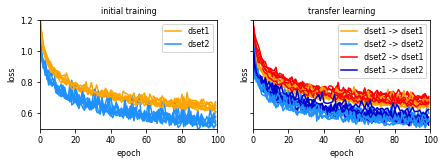

In [58]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)
fig.set_size_inches([7,2])
for i in range(7):
    ax[0].plot(training_dset1_hists[i]['val_loss'], 'orange', label='dset1' if i == 0 else None)
    ax[0].plot(training_dset2_hists[i]['val_loss'], 'dodgerblue', label='dset2' if i == 0 else None)
ax[0].legend(fontsize=8)
ax[0].set_xlabel('epoch', fontdict={'fontsize': 8})
ax[0].set_ylabel('loss', fontdict={'fontsize': 8})
ax[0].tick_params(labelsize=8)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.5, 1.2)
ax[0].set_title('initial training', fontdict={'fontsize': 8})
for i in range(7):
    ax[1].plot(transfer_dset1_dset1_hists[i]['val_loss'], 'orange', label='dset1 -> dset1' if i == 0 else None)
    ax[1].plot(transfer_dset2_dset2_hists[i]['val_loss'], 'dodgerblue', label='dset2 -> dset2' if i == 0 else None)
    ax[1].plot(transfer_dset2_dset1_hists[i]['val_loss'], 'red', label='dset2 -> dset1' if i == 0 else None)
    ax[1].plot(transfer_dset1_dset2_hists[i]['val_loss'], 'mediumblue', label='dset1 -> dset2' if i == 0 else None)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('epoch', fontdict={'fontsize': 8})
ax[1].set_ylabel('loss', fontdict={'fontsize': 8})
ax[1].tick_params(labelsize=8)
ax[1].set_title('transfer learning', fontdict={'fontsize': 8})
fig.savefig(os.path.join(fig_dir, 'training_transfer_learning_cifar5.pdf'), bbox_inches='tight')

In [12]:
weights_training_dset1 = []
weights_transfer_dset1_dset1 = []
weights_transfer_dset1_dset2 = []
weights_training_dset2 = []
weights_transfer_dset2_dset1 = []
weights_transfer_dset2_dset2 = []
for i in range(7):
    model = set_up_model()
    model.load_weights(os.path.join(savedir, 'weights_training_dset1_%d.h5'%i))
    weights_training_dset1.append(model.get_weights())
    model.load_weights(os.path.join(savedir, 'weights_training_dset2_%d.h5'%i))
    weights_training_dset2.append(model.get_weights())
    model.load_weights(os.path.join(savedir, 'weights_transfer_dset1_dset1_%d.h5'%i))
    weights_transfer_dset1_dset1.append(model.get_weights())
    model.load_weights(os.path.join(savedir, 'weights_transfer_dset1_dset2_%d.h5'%i))
    weights_transfer_dset1_dset2.append(model.get_weights())
    model.load_weights(os.path.join(savedir, 'weights_transfer_dset2_dset1_%d.h5'%i))
    weights_transfer_dset2_dset1.append(model.get_weights())
    model.load_weights(os.path.join(savedir, 'weights_transfer_dset2_dset2_%d.h5'%i))
    weights_transfer_dset2_dset2.append(model.get_weights())

# Check orthogonality of filters 

## Within each network

In [13]:
def unit_sphere(v):
    return v / np.sqrt((v**2).sum())

In [14]:
# (network, colour, filter, filter)
dotprod_arr = np.zeros([7, 3, 4, 4])
for i in range(7):
    for j in range(3):
        for k in range(4):
            for l in range(4):
                v1 = unit_sphere(weights_training_dset1[i][0][:,:,j,k].flatten())
                v2 = unit_sphere(weights_training_dset1[i][0][:,:,j,l].flatten())
                dotprod_arr[i, j, k, l] = np.dot(v1, v2)

In [15]:
# get upper triangles
triu = ~np.tri(4, dtype=np.bool)
triu_dots = []
for i in range(7):
    colors = []
    for j in range(3):
        colors.append(dotprod_arr[i, j][triu])
    triu_dots.append(colors)
triu_dots = np.array(triu_dots)

In [16]:
print(np.abs(triu_dots).mean())
print(np.abs(triu_dots).min())
print(np.abs(triu_dots).max())

0.16808128176951811
0.00025218259543180466
0.5463894605636597


## Between each network

In [17]:
dotprod_arr_dset1 = np.zeros([7, 7, 4, 4, 3])
for i in range(7):
    for j in range(7):
        for k in range(4):
            for l in range(4):
                for m in range(3):
                    v1 = unit_sphere(weights_training_dset1[i][0][:,:,m,k].flatten())
                    v2 = unit_sphere(weights_training_dset1[j][0][:,:,m,l].flatten())
                    dotprod_arr_dset1[i, j, k, l, m] = np.dot(v1, v2)
        
dotprod_arr_dset2 = np.zeros([7, 7, 4, 4, 3])
for i in range(7):
    for j in range(7):
        for k in range(4):
            for l in range(4):
                for m in range(3):
                    v1 = unit_sphere(weights_training_dset2[i][0][:,:,m,k].flatten())
                    v2 = unit_sphere(weights_training_dset2[j][0][:,:,m,l].flatten())
                    dotprod_arr_dset2[i, j, k, l, m] = np.dot(v1, v2)

dotprod_arr_dset1_dset2 = np.zeros([7, 7, 4, 4, 3])
for i in range(7):
    for j in range(7):
        for k in range(4):
            for l in range(4):
                for m in range(3):
                    v1 = unit_sphere(weights_training_dset1[i][0][:,:,m,k].flatten())
                    v2 = unit_sphere(weights_training_dset2[j][0][:,:,m,l].flatten())
                    dotprod_arr_dset1_dset2[i, j, k, l, m] = np.dot(v1, v2)

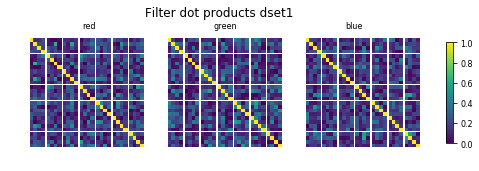

In [63]:
fig = plt.figure()
fig.set_size_inches([7,2])
fig.suptitle('Filter dot products dset1', fontdict={'fontsize': 8}, y=1.1)
gs_outer = gridspec.GridSpec(ncols=3, nrows=1)
gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[0], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1[i,j,:,:,0]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[1], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1[i,j,:,:,1]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[2], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1[i,j,:,:,2]), 0), vmin=0, vmax=1)
cax = plt.gcf().add_axes([0.95, 0.15, 0.015, 0.7])
cax.tick_params(labelsize=8)
plt.colorbar(mappable=im, cax=cax)
titles = ['red', 'green', 'blue']
for i in range(3):
    tax = fig.add_axes([0.23 + i*0.26, 0.95, 0.05, 0.05])
    tax.axis('off')
    tax.text(0, 0, titles[i], fontdict={'fontsize': 8})


fig.savefig(os.path.join(fig_dir, 'dset1_dot_products.pdf'), bbox_inches='tight')

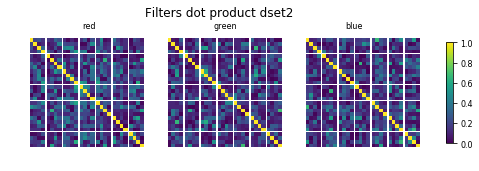

In [61]:
fig = plt.figure()
fig.set_size_inches([7,2])
fig.suptitle('Filters dot product dset2', fontdict={'fontsize': 8}, y=1.1)
gs_outer = gridspec.GridSpec(ncols=3, nrows=1)
gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[0], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset2[i,j,:,:,0]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[1], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset2[i,j,:,:,1]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[2], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset2[i,j,:,:,2]), 0), vmin=0, vmax=1)
cax = plt.gcf().add_axes([0.95, 0.15, 0.015, 0.7])
cax.tick_params(labelsize=8)
plt.colorbar(mappable=im, cax=cax)
titles = ['red', 'green', 'blue']
for i in range(3):
    tax = fig.add_axes([0.23 + i*0.26, 0.95, 0.05, 0.05])
    tax.axis('off')
    tax.text(0, 0, titles[i], fontdict={'fontsize': 8})
fig.savefig(os.path.join(fig_dir, 'dset2_dot_products.pdf'), bbox_inches='tight')

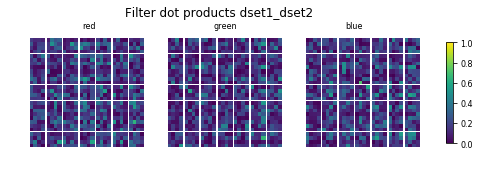

In [62]:
fig = plt.figure()
fig.set_size_inches([7,2])
fig.suptitle('Filter dot products dset1_dset2', fontdict={'fontsize': 8}, y=1.1)
gs_outer = gridspec.GridSpec(ncols=3, nrows=1)
gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[0], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1_dset2[i,j,:,:,0]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[1], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1_dset2[i,j,:,:,1]), 0), vmin=0, vmax=1)

gs = gridspec.GridSpecFromSubplotSpec(7, 7, gs_outer[2], hspace=0.05, wspace=0.05)
for i in range(7):
    for j in range(7):
        ax = plt.subplot(gs[i, j])
        ax.set_aspect('equal')
        ax.axis('off')
        im = ax.pcolormesh(np.flip(np.abs(dotprod_arr_dset1_dset2[i,j,:,:,2]), 0), vmin=0, vmax=1)
cax = plt.gcf().add_axes([0.95, 0.15, 0.015, 0.7])
cax.tick_params(labelsize=8)
plt.colorbar(mappable=im, cax=cax)
titles = ['red', 'green', 'blue']
for i in range(3):
    tax = fig.add_axes([0.23 + i*0.26, 0.95, 0.05, 0.05])
    tax.axis('off')
    tax.text(0, 0, titles[i], fontdict={'fontsize': 8})
fig.savefig(os.path.join(fig_dir, 'dset1_dset2_dot_products.pdf'), bbox_inches='tight')

In [94]:
weights_training_dset1[0][0].shape

(7, 7, 3, 4)

In [96]:
flat_unit_filters_dset1 = []
for i in range(7):
    fs = []
    for j in range(4):
        cs = []
        for k in range(3):
            v = weights_training_dset1[i][0][:,:,k,j].flatten()
            v = unit_sphere(v)
            cs.append(v)
        fs.append(cs)
    flat_unit_filters_dset1.append(fs)
flat_unit_filters_dset1 = np.array(flat_unit_filters_dset1)

In [97]:
flat_unit_filters_dset1.shape

(7, 4, 3, 49)

In [107]:
res_arr = np.zeros([7, 7, 3, 4])
for i in range(7):
    for j in range(7):
        for k in range(3):
            for l in range(4):
                basis_vs = flat_unit_filters_dset1[i,:,k,:].T
                target_v = flat_unit_filters_dset1[j,l,k,:]
                x, res, rank, s = np.linalg.lstsq(basis_vs, target_v)
                res_arr[i,j,k,l] = res

/home/jan-eirik/Documents/TensorFlow/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [112]:
res_arr.shape

(7, 7, 3, 4)

In [119]:
res_arr[res_arr > 0.01].min()

0.43528586626052856